## Covid Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime
from pathlib import Path

import keras as tk 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Add, add
from tensorflow.keras.layers import Input, InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, \
    GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger

from keras.applications import DenseNet121, ResNet50
from keras.applications.vgg16 import VGG16

from sklearn import metrics

%reload_ext tensorboard

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy' # categorical_crossentropy
model_metric = 'accuracy'
monitor_metric = 'val_accuracy' #'val_categorical_accuracy'
class_mode = 'sparse' # categorical
snapshots_dir = 'snapshots/'
history_dir = 'history/'
tenserboard_dir = 'logs/fit/'

seed = 100
epochs = 50
batch_size = 1
categories = ['Covid', 'Normal', 'Viral Pneumonia']
train_dir = './Covid19-dataset/train'
test_dir = './Covid19-dataset/test'
n_classes = len(categories)

img_width, img_height = 224, 224
input_shape=(img_width, img_height, 3)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                             # horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15)

#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_bfloat16')
#mixed_precision.set_global_policy(policy)

2024-02-14 10:52:03.972332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# !mkdir history

### Load and prepare data

In [4]:
def get_categories_df(dir):
    images = []
    for category in categories:
        files_path = os.path.join(dir, category)
        for path in Path(files_path).glob("*"):
            #print(path)
            images.append({"category": category, "file_name": os.path.join(*path.parts[-2:])})

    return pd.DataFrame(images).sample(frac = 1, random_state=seed)

train_df = get_categories_df(train_dir)
train_df

test_df = get_categories_df(test_dir)
test_df

category                                          file_name
41           Normal                                   Normal/0111.jpeg
32           Normal                                   Normal/0105.jpeg
12            Covid  Covid/auntminnie-a-2020_01_28_23_51_6665_2020_...
57  Viral Pneumonia                          Viral Pneumonia/0119.jpeg
58  Viral Pneumonia                          Viral Pneumonia/0107.jpeg
..              ...                                                ...
23            Covid                              Covid/COVID-00022.jpg
39           Normal                                   Normal/0108.jpeg
3             Covid                                     Covid/098.jpeg
24            Covid                                     Covid/0112.jpg
8             Covid                                     Covid/0111.jpg

[66 rows x 2 columns]

In [5]:
def get_iter(df, dir):
    return datagen.flow_from_dataframe(
        df,
        directory=dir,
        target_size=(img_width, img_height),
        x_col='file_name',
        y_col='category',
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=False
    )

train_iter = get_iter(train_df, train_dir)

test_iter = get_iter(test_df, test_dir)

Found 251 validated image filenames belonging to 3 classes.
Found 66 validated image filenames belonging to 3 classes.


### Prepare Models

In [6]:
# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss=entropy,
                    metrics=[model_metric])

In [7]:
def final_model(base_model):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.5))
    top_model.add(Dense(n_classes, activation='softmax'))

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    model.compile(loss=entropy,
                  optimizer='adam',
                  metrics=[model_metric])
    return model


def get_callbacks(model_name):
    log_dir= tenserboard_dir + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-Я%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    checkpoint_cb = ModelCheckpoint(snapshots_dir + model_name + "/{epoch:03d}-{" + monitor_metric + ":.5f}.weights.h5",
                                    monitor=monitor_metric,
                                    verbose=1,
                                    save_weights_only=True,
                                    save_best_only=True)
    
    es_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    csv_cb = CSVLogger(history_dir + model_name + '_training.log', separator=',', append=False)
    
    return [tensorboard_cb, checkpoint_cb, es_cb, csv_cb]


def fit_model(model, model_name):
    history = model.fit(train_iter, 
                        epochs=epochs,
                        callbacks=get_callbacks(model_name),
                        validation_data = test_iter
                       )

    return model, history

def load_DenseNet121():
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    model = final_model(base_model)
    return model

def load_VGG16():
    input_tensor = Input(shape=input_shape)
    base_model = VGG16(include_top=False,
                       weights='imagenet',
                       input_tensor=input_tensor)
    
    model = final_model(base_model)
    return model

def load_ResNet50():
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(pooling='avg',
                          include_top=False, 
                          input_tensor=input_tensor)
    
    model = final_model(base_model)
    return model

def load_AlexNet():
    return AlexNet((img_width, img_height, 3), n_classes)

### Fit models

In [8]:
# dense_model = load_DenseNet121()
# dense_model, dense_history = fit_model(dense_model, 'DenseNet121')

# vgg_model = load_VGG16()
# vgg_model, vgg_history = fit_model(vgg_model, 'VGG16')

# resnet_model = load_ResNet50()
#resnet_model, resnet_history = fit_model(resnet_model, 'ResNet50')

# alexnet_model = load_AlexNet()
# alexnet_model, alexnet_history = fit_model(resnet_model, 'AlexNet')

### Evaluate Models

In [26]:
%tensorboard --logdir logs/fit

In [9]:
model_names = ['DenseNet121', 'VGG16', 'ResNet50', 'AlexNet']
               
def load_saved_model(model_name):
    model = globals()['load_' + model_name]()
    checkpoints_dir = snapshots_dir + model_name
    best_weights = sorted(os.listdir(snapshots_dir + model_name), reverse=True)[0]
    print(best_weights)
    model.load_weights(checkpoints_dir + '/' + best_weights)
    return model

def load_saved_history(model_name):
    return  pd.read_csv(history_dir + model_name + '_training.log')

    return model, history_df

#### Model accuracy

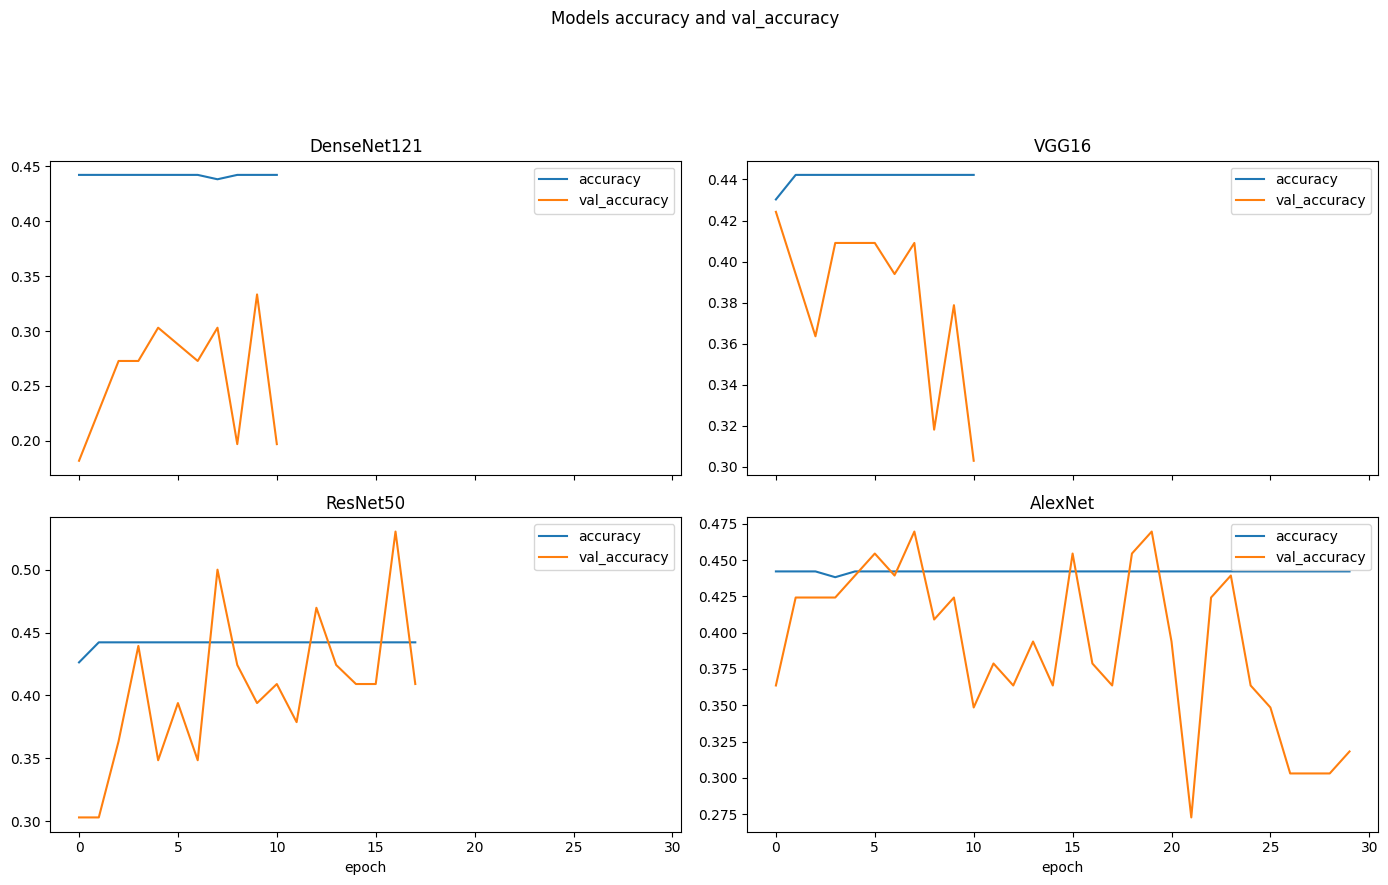

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

for cat, ax in enumerate(axes.flatten()):
    model_name = model_names[cat]
    df = load_saved_history(model_name)
    df.plot(ax=ax, x='epoch', y=['accuracy', 'val_accuracy'], title=model_name)

# Plot meta data
fig.suptitle("Models accuracy and val_accuracy", y=1.1)
fig.tight_layout()

#### Best model confusion matrix

In [11]:
best_model = load_saved_model("ResNet50")

2024-02-14 10:52:15.412055: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94765736/94765736 [==============================] - 10s 0us/step
017-0.53030.weights.h5


In [12]:
best_model.evaluate(test_iter)

66/66 [==============================] - 29s 413ms/step - loss: 8.9383 - accuracy: 0.4091


[8.938289642333984, 0.40909090638160706]

In [14]:
predictions = best_model.predict(test_iter, verbose=1)
preds = np.argmax(predictions, axis=1)

66/66 [==============================] - 32s 481ms/step


Accuracy 0.30


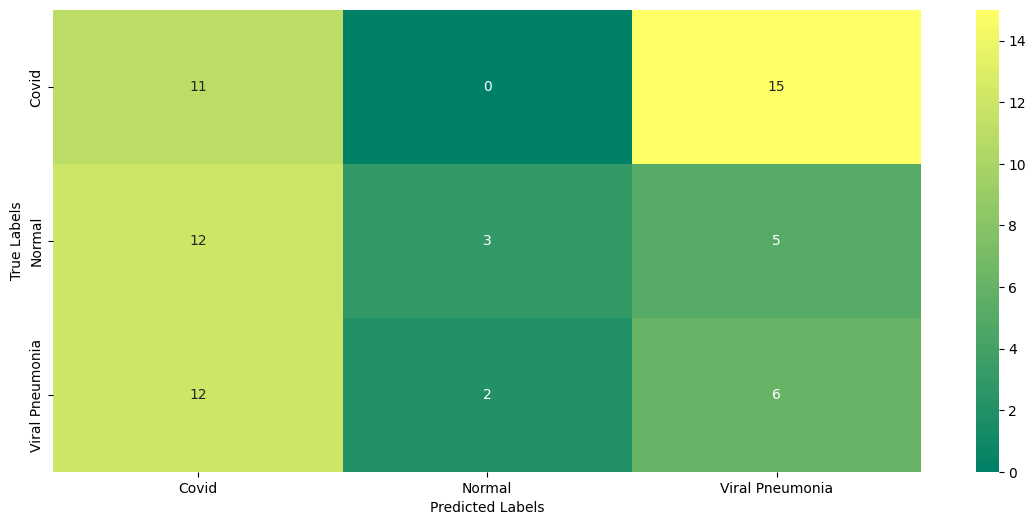

In [16]:
y_test = test_iter.labels
print('Accuracy %.2f' % metrics.accuracy_score(y_test, preds))

categories = test_iter.class_indices.keys()
    
plt.figure(figsize = (14,6))
sns.heatmap(metrics.confusion_matrix(y_test, preds), annot = True, fmt="d",
            xticklabels = categories, yticklabels = categories, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Research errors

In [17]:
def get_model_predictions(model_name):
    model = load_saved_model(model_name)
    predictions = best_model.predict(test_iter, verbose=1)
    return np.argmax(predictions, axis=1)

In [18]:
test_df2 = test_df.copy()
test_df2['labels'] = test_iter.labels

In [19]:
for model_name in ['DenseNet121', 'VGG16', 'ResNet50']:
    test_df2[model_name] = get_model_predictions(model_name)

010-0.33333.weights.h5


66/66 [==============================] - 28s 422ms/step
001-0.42424.weights.h5


66/66 [==============================] - 33s 498ms/step
017-0.53030.weights.h5


66/66 [==============================] - 30s 457ms/step


In [20]:
test_df2

category                                          file_name  \
41           Normal                                   Normal/0111.jpeg   
32           Normal                                   Normal/0105.jpeg   
12            Covid  Covid/auntminnie-a-2020_01_28_23_51_6665_2020_...   
57  Viral Pneumonia                          Viral Pneumonia/0119.jpeg   
58  Viral Pneumonia                          Viral Pneumonia/0107.jpeg   
..              ...                                                ...   
23            Covid                              Covid/COVID-00022.jpg   
39           Normal                                   Normal/0108.jpeg   
3             Covid                                     Covid/098.jpeg   
24            Covid                                     Covid/0112.jpg   
8             Covid                                     Covid/0111.jpg   

    labels  DenseNet121  VGG16  ResNet50  
41       1            0      0         0  
32       1            1      0         1  
12       0            0      0         0  
57       2            2      2         1  
58       2            1      2         1  
..     ...          ...    ...       ...  
23       0            0      0         2  
39       1            0      1         0  
3        0            0      0         0  
24       0            0      0         0  
8        0            2      2         2  

[66 rows x 6 columns]

#### Wrong predictions

In [21]:
wrong_preds_df = test_df2[(test_df2['labels'] != test_df2['DenseNet121']) & \
    (test_df2['labels'] != test_df2['VGG16']) & \
    (test_df2['labels'] != test_df2['ResNet50'])]

In [22]:
wrong_preds_df = wrong_preds_df.reset_index()
wrong_preds_df['category'].value_counts()

category
Normal             10
Covid               8
Viral Pneumonia     6
Name: count, dtype: int64

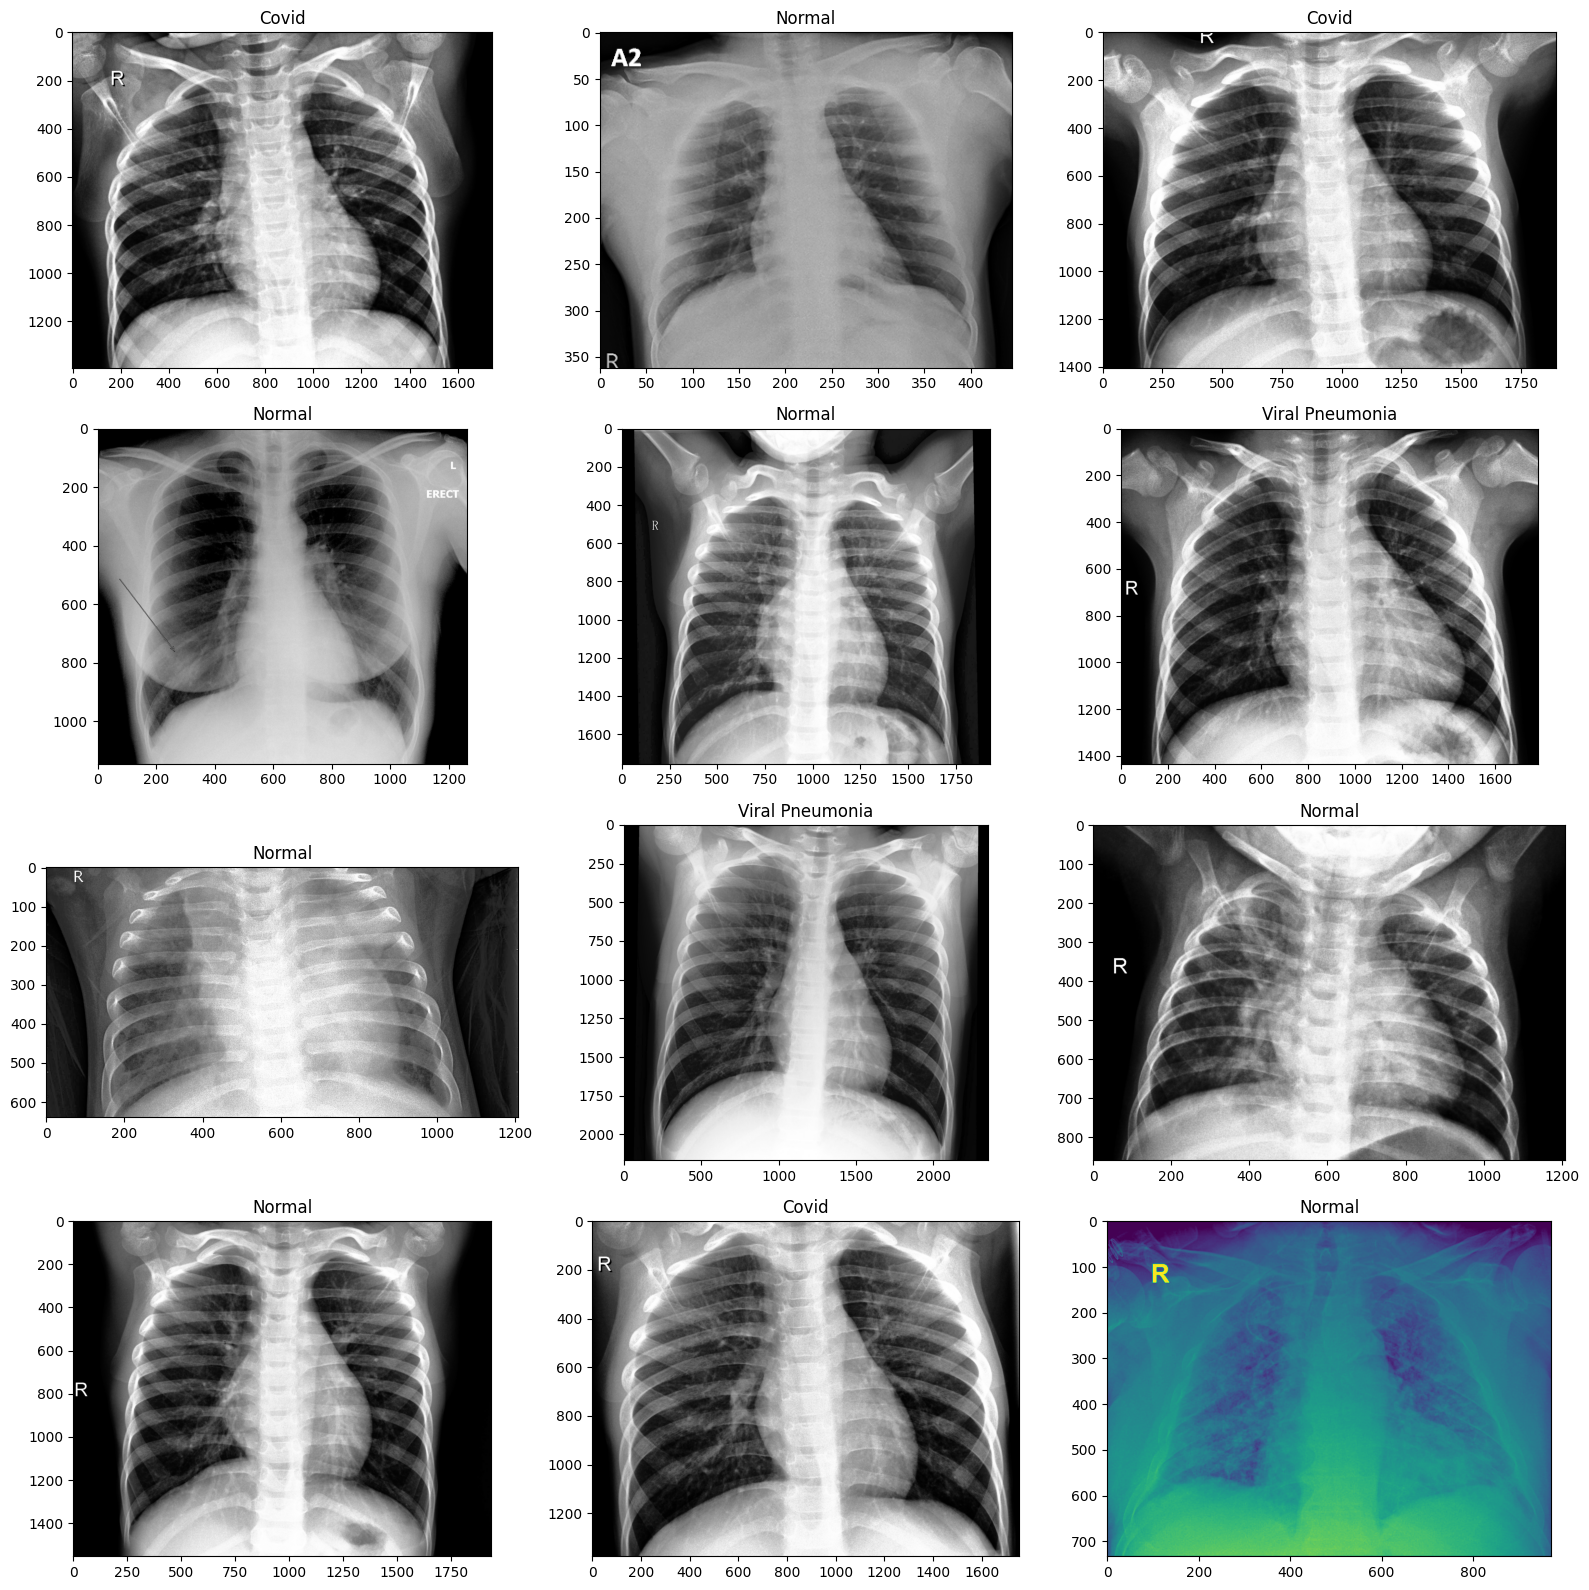

In [23]:
fig, ax=plt.subplots(4, 3)
fig.set_size_inches(16, 16)

ind = 0
for i in range(4):
    for j in range (3):
            img_path = test_dir + '/' + wrong_preds_df.loc[ind, 'file_name']
            ind = ind +1
            ax[i,j].imshow(plt.imread(img_path))
            ax[i,j].set_title(wrong_preds_df.loc[ind, 'category'])
        
plt.tight_layout()

#### Correct predictions

In [24]:
correct_preds_df = test_df2[(test_df2['labels'] == test_df2['DenseNet121']) & \
    (test_df2['labels'] == test_df2['VGG16']) & \
    (test_df2['labels'] == test_df2['ResNet50'])]

In [25]:
correct_preds_df = correct_preds_df.reset_index()
correct_preds_df['category'].value_counts()

category
Covid              10
Normal              2
Viral Pneumonia     1
Name: count, dtype: int64

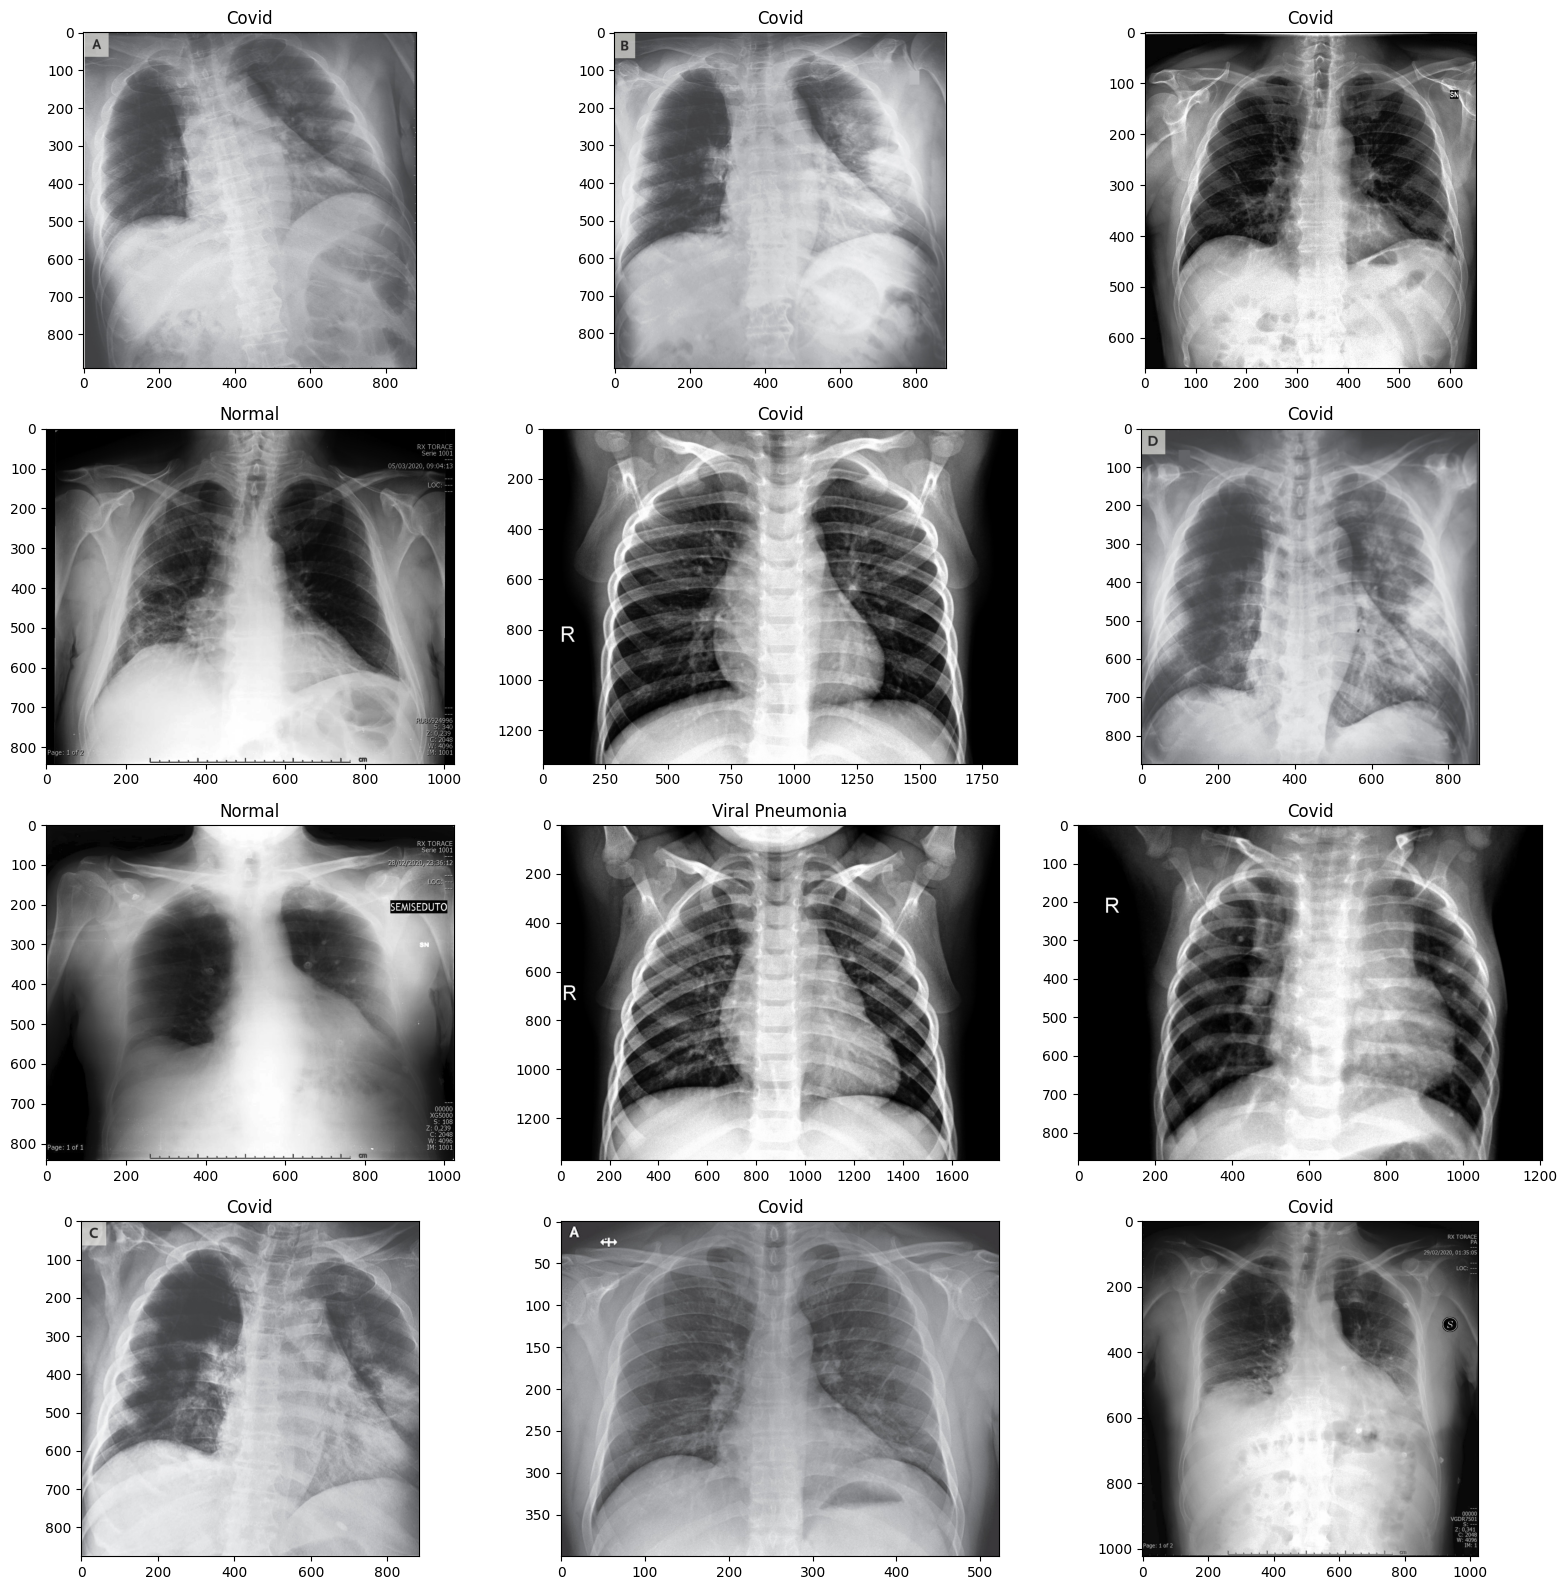

In [26]:
fig, ax=plt.subplots(4, 3)
fig.set_size_inches(16, 16)

ind = 0
for i in range(4):
    for j in range (3):
            img_path = test_dir + '/' + correct_preds_df.loc[ind, 'file_name']
            ind = ind +1
            ax[i,j].imshow(plt.imread(img_path))
            ax[i,j].set_title(correct_preds_df.loc[ind, 'category'])
        
plt.tight_layout()